In [1]:
from PIL import Image
import numpy as np
import os

# File paths for the uploaded images
image_files = [
    '/content/1.jpg',
    '/content/2.png',
    '/content/3.jpg',
    '/content/4.jpg',
    '/content/5.jpg',
    '/content/6.jpg',
    '/content/7.png',
    '/content/8.png',
    '/content/9.jpg',
    '/content/10.png'
]

# Function to load images and convert them to grayscale
def load_and_preprocess_image(file_path):
    with Image.open(file_path) as img:
        # Convert image to grayscale
        img_gray = img.convert('L')
        # Convert image to a numpy array and flatten it
        img_array = np.array(img_gray).flatten()
    return img_array

# Load and preprocess all images
preprocessed_images = np.array([load_and_preprocess_image(file) for file in image_files])

# Check the shape of the resulting matrix
preprocessed_images.shape

(10, 2073600)

In [2]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the image data by scaling to zero mean and unit variance
normalized_images = scaler.fit_transform(preprocessed_images)

# Compute SVD
U, S, VT = np.linalg.svd(normalized_images, full_matrices=False)

# Check the shapes of the decomposed matrices
U.shape, S.shape, VT.shape

((10, 10), (10,), (10, 2073600))

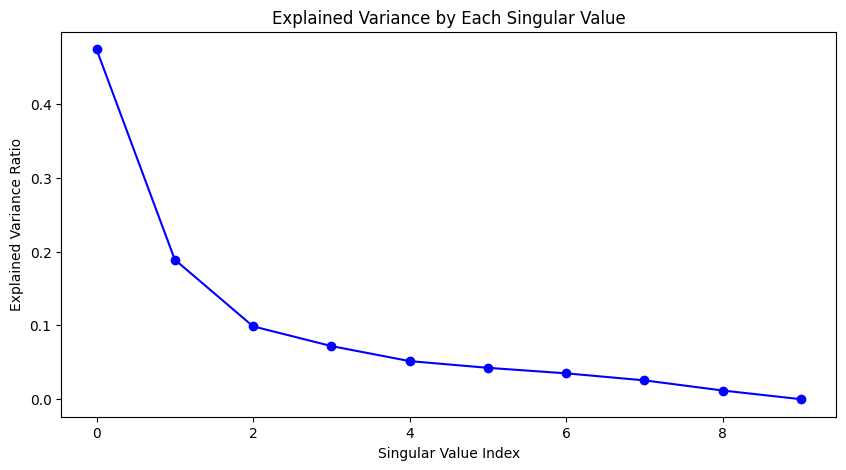

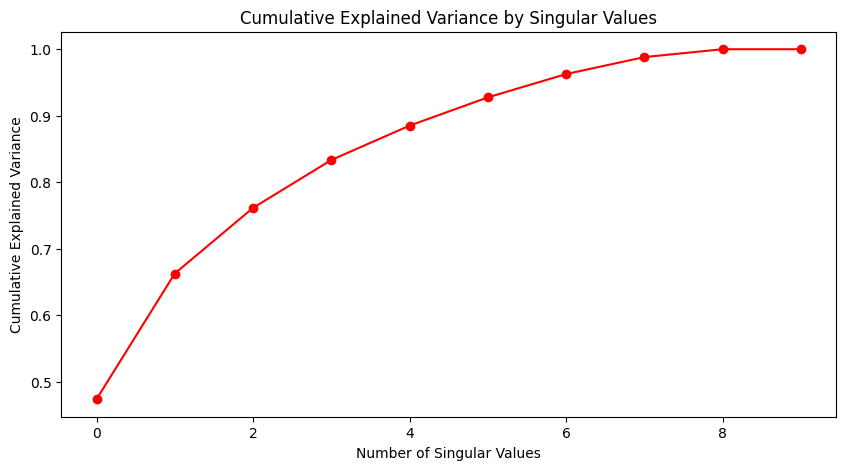

(7, 0.9626977774448353)

In [3]:
import matplotlib.pyplot as plt

# Calculate the explained variance from the singular values
explained_variance = np.square(S) / np.sum(np.square(S))

# Plot the explained variance
plt.figure(figsize=(10,5))
plt.plot(explained_variance, 'bo-')
plt.title('Explained Variance by Each Singular Value')
plt.xlabel('Singular Value Index')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10,5))
plt.plot(cumulative_explained_variance, 'ro-')
plt.title('Cumulative Explained Variance by Singular Values')
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# How much variance we want to retain
desired_variance = 0.95  # For example, let's retain 95% of the variance

# Find the number of singular values needed to retain the desired variance
num_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

num_components, cumulative_explained_variance[num_components-1]  # Returns the number of components and the actual variance retained

In [4]:
# Project the normalized images onto the reduced space
reduced_data = np.dot(U[:, :num_components], np.diag(S[:num_components]))

# Check the shape of the reduced data
reduced_data.shape

# Now, we will also reconstruct the images from the reduced dimensions to check the results of dimensionality reduction.
# Reconstruct the images from the reduced dimensions
reconstructed_images = np.dot(reduced_data, VT[:num_components, :])

# Reverse the preprocessing step (normalization)
reconstructed_images = scaler.inverse_transform(reconstructed_images)

# Check the shape of the reconstructed images
reconstructed_images.shape

(10, 2073600)

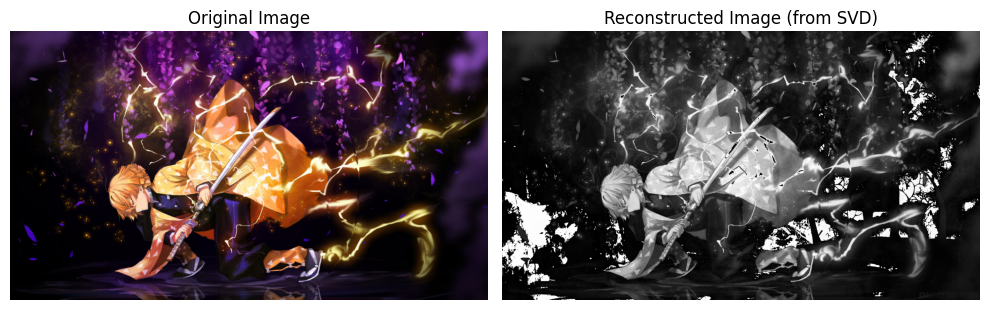

In [5]:
# Function to reshape the flattened image back to its original 2D shape
def reshape_to_original(img_flat, img_shape):
    return img_flat.reshape(img_shape)

# Let's assume all images had the same shape for simplicity. We'll use the shape of the first image.
original_shape = Image.open(image_files[0]).size[::-1] # PIL reads in (width, height) order, we need (height, width)

# Reshape the reconstructed images
reshaped_reconstructed_images = np.array([reshape_to_original(img, original_shape) for img in reconstructed_images])

# Now let's visualize the first original and reconstructed image as an example
original_img = Image.open(image_files[0])
reconstructed_img = Image.fromarray(reshaped_reconstructed_images[0].astype(np.uint8))

# Display the original and the reconstructed image side by side
plt.figure(figsize=(10,5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed Image (from SVD)')
plt.axis('off')

plt.tight_layout()
plt.show()

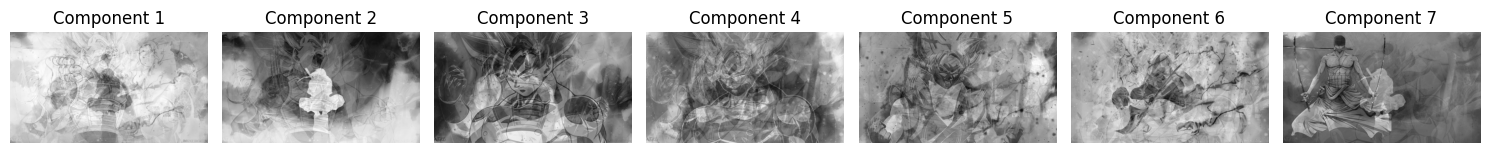

In [6]:
# Function to display eigenimages / principal components
def display_eigenimages(VT, num_components, img_shape):
    fig, axes = plt.subplots(1, num_components, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        # Reshape the component to the size of the original image
        eigenimage = VT[i].reshape(img_shape)
        ax.imshow(eigenimage, cmap='gray')
        ax.set_title(f'Component {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first few eigenimages
display_eigenimages(VT, num_components, original_shape)

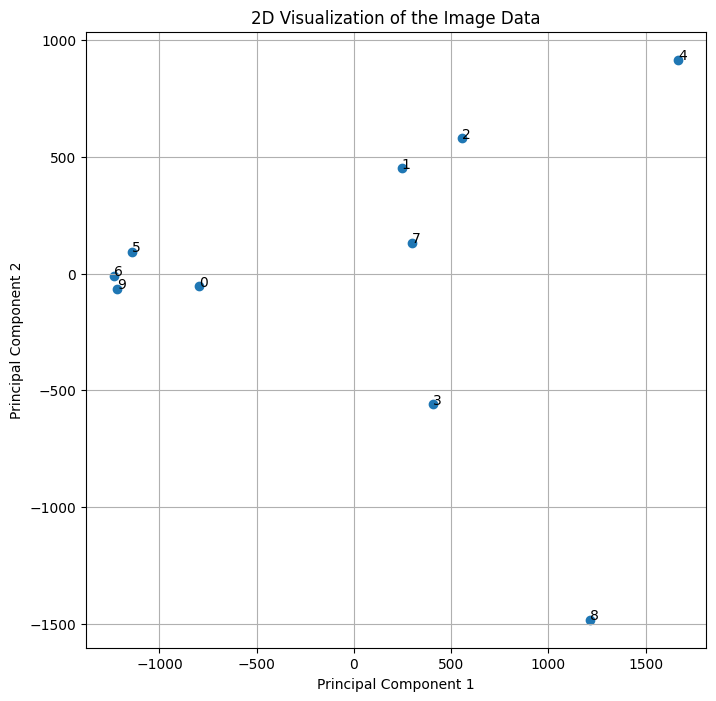

In [7]:
# Further reduce the data to 2 dimensions for visualization purposes
reduced_data_2d = U[:, :2] * S[:2]

# Plot the 2D projection of the images
plt.figure(figsize=(8, 8))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], marker='o')
plt.title('2D Visualization of the Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(range(reduced_data_2d.shape[0])):
    plt.annotate(txt, (reduced_data_2d[i, 0], reduced_data_2d[i, 1]))
plt.grid(True)
plt.show()

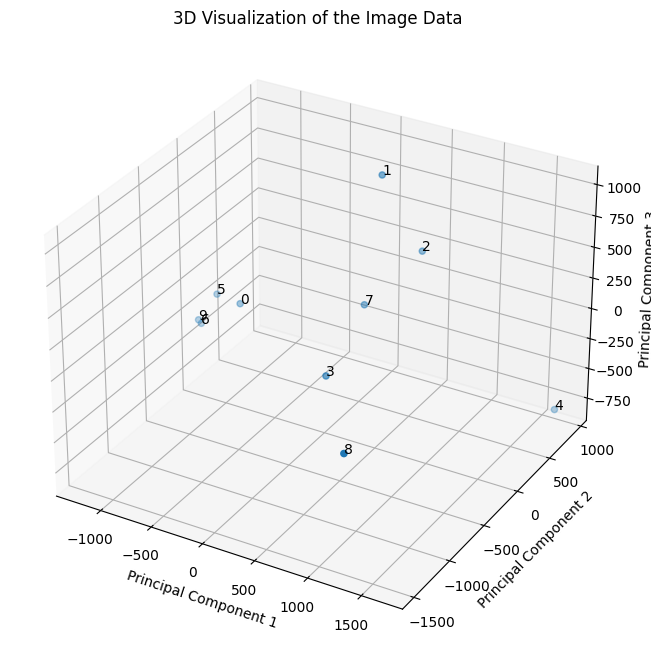

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Further reduce the data to 3 dimensions for 3D visualization purposes
reduced_data_3d = U[:, :3] * S[:3]

# Plot the 3D projection of the images
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2], marker='o')

ax.set_title('3D Visualization of the Image Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
for i, txt in enumerate(range(reduced_data_3d.shape[0])):
    ax.text(reduced_data_3d[i, 0], reduced_data_3d[i, 1], reduced_data_3d[i, 2], txt)
plt.show()